## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres: 
Lupe Pinzón, Camilo Angarita, Juan Andrés Cabal

**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

In [1]:
import numpy as np
import keras
from keras import layers
from keras.models import load_model, Sequential

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 


También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [2]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [3]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=max_features)

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 secuencias de entrenamiento
25000 secuencias de validación


**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la priemra observación de entrenamiento:

In [4]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [5]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

Veamos el primer comentario de entrenamiento que es positivo:

In [6]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [7]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [8]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 184s 471ms/step - loss: 0.5528 - accuracy: 0.7212 - val_loss: 0.4916 - val_accuracy: 0.7681
Epoch 2/3
391/391 [==============================] - 175s 447ms/step - loss: 0.3480 - accuracy: 0.8494 - val_loss: 0.4384 - val_accuracy: 0.8236
Epoch 3/3
391/391 [==============================] - 173s 443ms/step - loss: 0.2478 - accuracy: 0.9052 - val_loss: 0.4327 - val_accuracy: 0.8235
Desempeño (exactitud): accu_v1=0.8235200047492981 , accu_v2=0.8149999976158142
Epoch 1/3
391/391 [==============================] - 172s 440ms/step - loss: 0.2678 - accuracy: 0.8946 - val_loss: 0.2451 - val_accuracy: 0.9018
Epoch 2/3
391/391 [==============================] - 149s 380ms/step - loss: 0.1607 - accuracy: 0.9454 - val_loss: 0.2646 - val_accuracy: 0.9053
Epoch 3/3
391/391 [==============================] - 103s 264ms/step - loss: 0.1056 - accuracy: 0.9657 - val_loss: 0.3368 - val_accuracy: 0.8835
Desempeño (exactitud): accu_v1=0.8835200071334839 ,

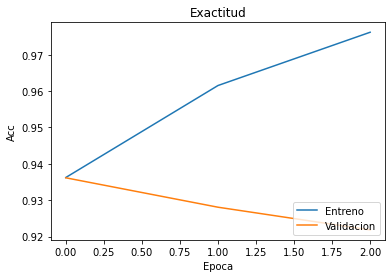

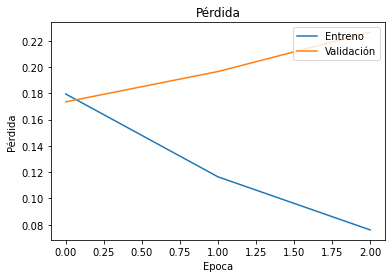

In [10]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [11]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part=3.h5')

model_brnn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [12]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[10473  2027]
 [  968 11532]]
Exactitud:  0.8802000284194946


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [13]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9593  2907]
 [ 1718 10782]]
Exactitud:  0.8149999976158142


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con esta red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

In [14]:
# Implementamos una red neuronal recurrente uni-direccional

# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM 
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('URNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 93s 239ms/step - loss: 0.4465 - accuracy: 0.7894 - val_loss: 0.4082 - val_accuracy: 0.8202
Epoch 2/3
391/391 [==============================] - 107s 275ms/step - loss: 0.2193 - accuracy: 0.9187 - val_loss: 0.3466 - val_accuracy: 0.8520
Epoch 3/3
391/391 [==============================] - 116s 296ms/step - loss: 0.1374 - accuracy: 0.9525 - val_loss: 0.4039 - val_accuracy: 0.8502
Desempeño (exactitud): accu_v1=0.8502399921417236 , accu_v2=0.8388000130653381
Epoch 1/3
391/391 [==============================] - 137s 350ms/step - loss: 0.2478 - accuracy: 0.9059 - val_loss: 0.2310 - val_accuracy: 0.9175
Epoch 2/3
391/391 [==============================] - 124s 316ms/step - loss: 0.1245 - accuracy: 0.9576 - val_loss: 0.3078 - val_accuracy: 0.9101
Epoch 3/3
391/391 [==============================] - 122s 313ms/step - loss: 0.0672 - accuracy: 0.9786 - val_loss: 0.3811 - val_accuracy: 0.9034
Desempeño (exactitud): accu_v1=0.9033600091934204 , 

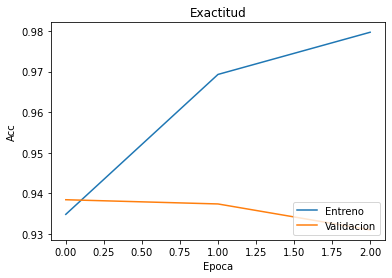

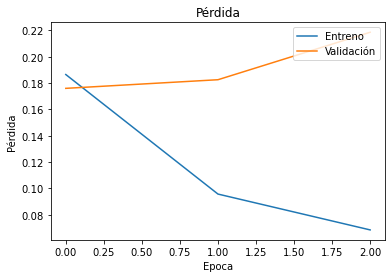

In [16]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [35]:
# B-RNN LSTM
model_urnn = load_model('URNN_part=3.h5')

model_urnn.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [36]:
Y_predt = model_urnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_urnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11596   904]
 [ 1186 11314]]
Exactitud:  0.9164000153541565


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [37]:
Y_predv = model_urnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_urnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10784  1716]
 [ 2314 10186]]
Exactitud:  0.8388000130653381


Al utilizar una red neuronal recurrente uni-direccional con dos capas escodidas encontramos que la exactitud del modelo mejora con respecto a la red neuronal recurrente bidireccional. Sin embargo, observamos que el modelo no parece converger por cuanto la gráfica de exactitud y perdida tienden a separarse a medida que aumentan las epocas. Por esta razón, a continuación, intentaremos ver si al modificar la red y agregar capas escondidas adicionales es posible mejorar la exactitud del modelo.

In [25]:
# Implementamos una red neuronal recurrente uni-direccional

# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 3 unidades LSTM 
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.Dropout(0.20)(x)

x = layers.LSTM(64,  return_sequences=True)(x)
x = layers.Dropout(0.20)(x)

x = layers.LSTM(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model3 = keras.Model(inputs, outputs)
model3.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)              

In [26]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('URNN_part3='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 167s 427ms/step - loss: 0.4492 - accuracy: 0.7855 - val_loss: 0.3341 - val_accuracy: 0.8643
Epoch 2/3
391/391 [==============================] - 171s 437ms/step - loss: 0.2240 - accuracy: 0.9180 - val_loss: 0.3812 - val_accuracy: 0.8553
Epoch 3/3
391/391 [==============================] - 171s 437ms/step - loss: 0.2041 - accuracy: 0.9285 - val_loss: 0.4309 - val_accuracy: 0.8223
Desempeño (exactitud): accu_v1=0.8223199844360352 , accu_v2=0.8154399991035461
Epoch 1/3
391/391 [==============================] - 175s 448ms/step - loss: 0.2721 - accuracy: 0.8960 - val_loss: 0.2425 - val_accuracy: 0.9139
Epoch 2/3
391/391 [==============================] - 193s 493ms/step - loss: 0.1298 - accuracy: 0.9579 - val_loss: 0.2883 - val_accuracy: 0.9090
Epoch 3/3
391/391 [==============================] - 200s 512ms/step - loss: 0.0607 - accuracy: 0.9825 - val_loss: 0.4574 - val_accuracy: 0.8938
Desempeño (exactitud): accu_v1=0.8937600255012512 ,

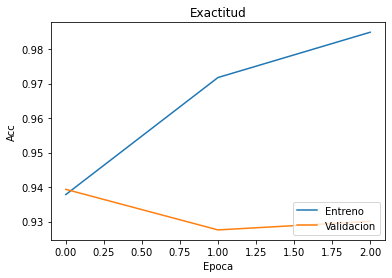

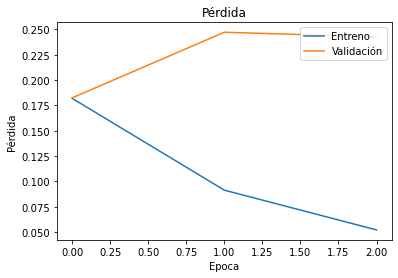

In [27]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [38]:
# B-RNN LSTM
model_nn = load_model('URNN_part3=3.h5')

model_nn.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [39]:
Y_predt = model_nn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_nn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[10662  1838]
 [ 1037 11463]]
Exactitud:  0.8849999904632568


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [40]:
Y_predv = model_nn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_nn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9661  2839]
 [ 1775 10725]]
Exactitud:  0.8154399991035461


Al ver los resultados de la red neuronal recurrente con capas adicionales encontramos que la exactitud del modelo cae, lo que implica que el modelo uni-direccional con 2 capas sigue teniendo la mejor capacidad predictiva, aunque no logra converger. Por esta razón, con el fin de ver si es posible obtener un mejor resultados, intentaremos una red neuronal recurrente GRU.

In [41]:
# Implementamos una red neuronal recurrente GRU

# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades GRU
x = layers.GRU(64, return_sequences=True)(x)
x = layers.Dropout(0.20)(x)
x = layers.GRU(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model4 = keras.Model(inputs, outputs)
model4.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru (GRU)                    (None, None, 64)          37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,622,273
Trainable params: 2,622,273
Non-trainable params: 0
___________________________________________

In [42]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('GRU_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 151s 387ms/step - loss: 0.4857 - accuracy: 0.7527 - val_loss: 0.3488 - val_accuracy: 0.8543
Epoch 2/3
391/391 [==============================] - 148s 379ms/step - loss: 0.2357 - accuracy: 0.9102 - val_loss: 0.3568 - val_accuracy: 0.8682
Epoch 3/3
391/391 [==============================] - 142s 363ms/step - loss: 0.1215 - accuracy: 0.9570 - val_loss: 0.5201 - val_accuracy: 0.8507
Desempeño (exactitud): accu_v1=0.8507199883460999 , accu_v2=0.8392400145530701
Epoch 1/3
391/391 [==============================] - 156s 400ms/step - loss: 0.2222 - accuracy: 0.9184 - val_loss: 0.2002 - val_accuracy: 0.9270
Epoch 2/3
391/391 [==============================] - 151s 387ms/step - loss: 0.0859 - accuracy: 0.9728 - val_loss: 0.2608 - val_accuracy: 0.9070
Epoch 3/3
391/391 [==============================] - 152s 390ms/step - loss: 0.0412 - accuracy: 0.9870 - val_loss: 0.4178 - val_accuracy: 0.8943
Desempeño (exactitud): accu_v1=0.894320011138916 , 

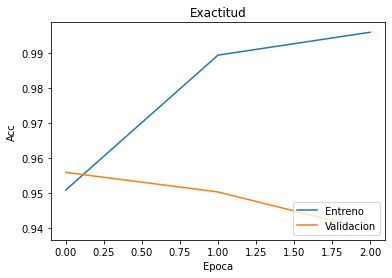

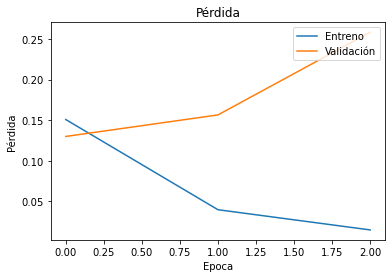

In [43]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc = 'lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [44]:
# B-RNN LSTM
model_gru = load_model('GRU_part=3.h5')

model_gru.summary()

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru (GRU)                    (None, None, 64)          37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,622,273
Trainable params: 2,622,273
Non-trainable params: 0
___________________________________________

Replicamos los resultados obtenidos anteriormente:

In [45]:
Y_predt = model_gru.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_gru.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[10894  1606]
 [  560 11940]]
Exactitud:  0.9133599996566772


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [46]:
Y_predv = model_gru.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_gru.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9684  2816]
 [ 1203 11297]]
Exactitud:  0.8392400145530701


Los resultados de la Red GRU no son tan diferentes a los de la red neuronal unidireccional, existiendo una leve mejora en terminos de predicción sobre los datos de prueba. Sigue exitiendo, no obstante, el problema relacionado con la no convergencia del modelo, lo cual puede estar relacionado con un posible overfitting. Por esta razón, intentaremos modificar algunos de los parametros de la red GRU con el fin de ver si es posible obtener una mejor exactitud y convergencia del modelo.

In [47]:
# Implementamos una red neuronal recurrente uni-direccional

# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 3 unidades GRU
x = layers.GRU(64, return_sequences=True)(x)
x = layers.Dropout(0.20)(x)

x = layers.GRU(30, return_sequences=True)(x)
x = layers.Dropout(0.20)(x)

x = layers.GRU(30)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model5 = keras.Model(inputs, outputs)
model5.summary()

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          37248     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, None, 30)          8640      
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 30)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 30)              

In [48]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.3, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('GRU2_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
547/547 [==============================] - 104s 190ms/step - loss: 0.4476 - accuracy: 0.7900 - val_loss: 0.3061 - val_accuracy: 0.8773
Epoch 2/3
547/547 [==============================] - 115s 211ms/step - loss: 0.2146 - accuracy: 0.9207 - val_loss: 0.3156 - val_accuracy: 0.8768
Epoch 3/3
547/547 [==============================] - 126s 230ms/step - loss: 0.1382 - accuracy: 0.9509 - val_loss: 0.4302 - val_accuracy: 0.8612
Desempeño (exactitud): accu_v1=0.8611999750137329 , accu_v2=0.8491600155830383
Epoch 1/3
547/547 [==============================] - 150s 275ms/step - loss: 0.1595 - accuracy: 0.9455 - val_loss: 0.1577 - val_accuracy: 0.9460
Epoch 2/3
547/547 [==============================] - 148s 270ms/step - loss: 0.0674 - accuracy: 0.9799 - val_loss: 0.2159 - val_accuracy: 0.9389
Epoch 3/3
547/547 [==============================] - 149s 272ms/step - loss: 0.0402 - accuracy: 0.9882 - val_loss: 0.3225 - val_accuracy: 0.9240
Desempeño (exactitud): accu_v1=0.9240000247955322 ,

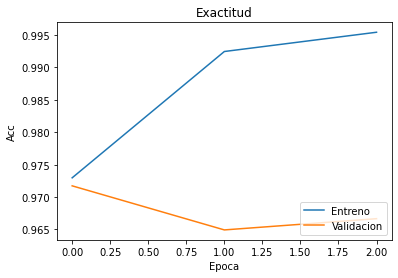

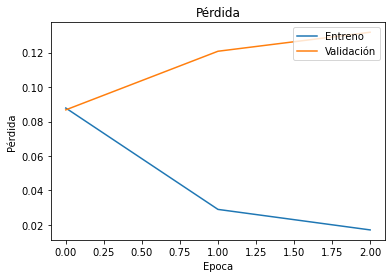

In [50]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc = 'lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [51]:
# B-RNN LSTM
model_gru2 = load_model('GRU2_part=3.h5')

model_gru2.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          37248     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, None, 30)          8640      
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 30)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 30)              

Replicamos los resultados obtenidos anteriormente:

In [52]:
Y_predt = model_gru2.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_gru2.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11368  1132]
 [  366 12134]]
Exactitud:  0.9400799870491028


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [53]:
Y_predv = model_gru2.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_gru2.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9936  2564]
 [ 1207 11293]]
Exactitud:  0.8491600155830383


Al cambiar la configuración inicial de la Red Neuronal GRU con tres capas escondidas y hacienda el entrenamiento y validación con una partición del 30% encontramos que la exactitud del modelo mejora con respecto al modelo anterior; sin embargo, seguimos sin conseguir que el modelo converga y que se tenga un posible overfitting sobre la muestra de prueba.

## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

In [53]:
# Modelo base

Y_predv = model_gru2.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_gru2.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9936  2564]
 [ 1207 11293]]
Exactitud:  0.8491600155830383


In [11]:
# Modelo LSTM 

# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM 
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model6 = keras.Model(inputs, outputs)
model6.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas = 20

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.3, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('LSTM_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/20
547/547 [==============================] - 180s 328ms/step - loss: 0.4402 - accuracy: 0.7966 - val_loss: 0.3507 - val_accuracy: 0.8575
Epoch 2/20
547/547 [==============================] - 170s 311ms/step - loss: 0.2384 - accuracy: 0.9081 - val_loss: 0.3546 - val_accuracy: 0.8517
Epoch 3/20
547/547 [==============================] - 168s 308ms/step - loss: 0.1509 - accuracy: 0.9458 - val_loss: 0.4975 - val_accuracy: 0.8272
Epoch 4/20
547/547 [==============================] - 179s 328ms/step - loss: 0.1209 - accuracy: 0.9577 - val_loss: 0.5578 - val_accuracy: 0.8395
Epoch 5/20
547/547 [==============================] - 189s 345ms/step - loss: 0.0948 - accuracy: 0.9670 - val_loss: 0.5998 - val_accuracy: 0.8391
Epoch 6/20
547/547 [==============================] - 190s 348ms/step - loss: 0.0733 - accuracy: 0.9737 - val_loss: 0.6771 - val_accuracy: 0.8363
Epoch 7/20
547/547 [==============================] - 189s 346ms/step - loss: 0.0585 - accuracy: 0.9806 - val_loss: 0.6542 -

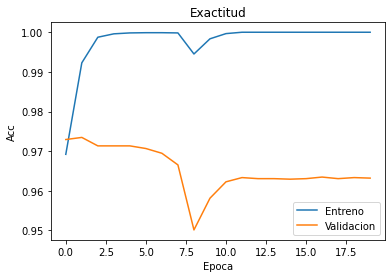

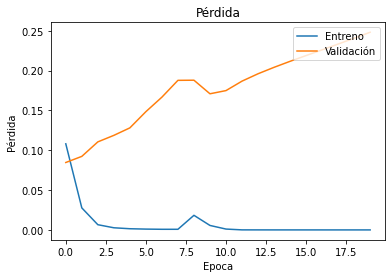

In [13]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc = 'lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [14]:
# B-RNN LSTM
model_lstm = load_model('LSTM_part=3.h5')

model_lstm.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [15]:
Y_predt = model_lstm.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_lstm.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11977   523]
 [  729 11771]]
Exactitud:  0.9499199986457825


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [16]:
Y_predv = model_lstm.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_lstm.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10716  1784]
 [ 2705  9795]]
Exactitud:  0.8204399943351746


El modelo inicial que mostro tener el mejor desempeño fue la red neuronal recurrente de tipo GRU con una exactitus sobre la base de prueba igual a 84.91%. Dado que en la anteriores modelos se tuvo siempre en cuenta el número de capas escondidas, lo que intentamos en esta ocasión fue cambiar la cantidad de épocas a 20 con el fin de observar una mejoria en la exactitud del modelo. Para ello decidimos utilizar una red neuronal recurrente de tipo LSTM con dos capas escodindas; sin embargo, tras correr el modelo encontramos un buen desempeño sobre la prueba de entrenamiento (94.99%), pero con resultados inferiores sobre la base de prueba en relación al modelo GRU (82.04%). 

En este caso, de igual forma, es posible ver que el modelo no converge, siendo la exactitud sobre la base prueba casi igual a 100% desde la segunda epoca. Esto, al contrario, no sucede con el desempeño sobre la validación, la cual alcanza, a lo sumo, un valor igual a 97% en la rpimera epoca y luego empieza a caer. Este resultado da a pensar que seguimos generando un modelo que hace overfitting de la data.

Dado este resultado, vamos a intentar resolver el problema utilizando una red convolucional.

In [28]:
# Modelo CNN

# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM 
x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D()(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(250, activation = 'relu')(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_11 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          12320     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               8250      
_________________________________________________________________
dense_5 (Dense)              (None, 1)               

In [29]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas = 3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.3, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('CNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
547/547 [==============================] - 22s 40ms/step - loss: 0.4257 - accuracy: 0.7969 - val_loss: 0.3015 - val_accuracy: 0.8720
Epoch 2/3
547/547 [==============================] - 24s 44ms/step - loss: 0.1617 - accuracy: 0.9374 - val_loss: 0.3415 - val_accuracy: 0.8721
Epoch 3/3
547/547 [==============================] - 23s 43ms/step - loss: 0.0369 - accuracy: 0.9893 - val_loss: 0.3980 - val_accuracy: 0.8795
Desempeño (exactitud): accu_v1=0.8794666528701782 , accu_v2=0.8686800003051758
Epoch 1/3
547/547 [==============================] - 25s 46ms/step - loss: 0.1434 - accuracy: 0.9489 - val_loss: 0.1354 - val_accuracy: 0.9528
Epoch 2/3
547/547 [==============================] - 24s 45ms/step - loss: 0.0193 - accuracy: 0.9954 - val_loss: 0.1494 - val_accuracy: 0.9559
Epoch 3/3
547/547 [==============================] - 26s 47ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1555 - val_accuracy: 0.9576
Desempeño (exactitud): accu_v1=0.9575999975204468 , accu_v2=0.8

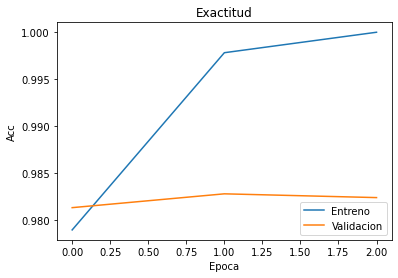

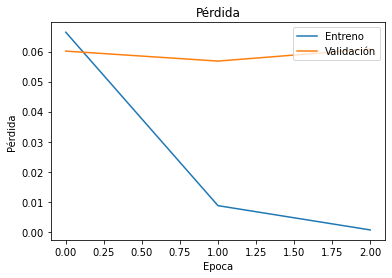

In [30]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc = 'lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [31]:
# B-RNN LSTM
model_cnn = load_model('CNN_part=3.h5')

model_cnn.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_11 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          12320     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               8250      
_________________________________________________________________
dense_5 (Dense)              (None, 1)               

Replicamos los resultados obtenidos anteriormente:

In [32]:
Y_predt = model_cnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_cnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[12061   439]
 [  482 12018]]
Exactitud:  0.96315997838974


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [33]:
Y_predv = model_cnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_cnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10985  1515]
 [ 1768 10732]]
Exactitud:  0.8686800003051758


Al intentar una red convolucional con una capa MaxPooling que extrae el valor máximo del área que extrae el valor máximo del área que convoluciona, una capa Global MaxPooling que establece el tamaño del pool igual al tamaño de entrada, de modo que el máximo de toda la entrada se calcula como el valor de salida, una capa densa y una capa de salida final. 

En este caso, bajo esta configuración encontramos que la exactitud del modelo mejora con respecto a la red neruronal recurrente de tipo GRU y pasa de 84.91% a 86.86%, lo que convierte a la red convolucional como el mejor modelo para clasificar los sentimientos de las peliculas. 

A pesar de la mejoría en la exactitud de la red convolucional, queremos ver si es posible modificar este tipo de red con el fin de generar una mejor exactitud, así como una posible convergencia del modelo. 

In [36]:
# Modelo CNN

# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM 
x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D()(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(250, activation = 'relu')(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_14 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          12320     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 250)               8250      
_________________________________________________________________
dense_9 (Dense)              (None, 1)               

In [37]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas = 3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

#Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.3, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('CNNrms_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
547/547 [==============================] - 32s 58ms/step - loss: 0.6849 - accuracy: 0.6309 - val_loss: 0.6656 - val_accuracy: 0.7304
Epoch 2/3
547/547 [==============================] - 35s 63ms/step - loss: 0.6174 - accuracy: 0.7465 - val_loss: 0.5655 - val_accuracy: 0.7564
Epoch 3/3
547/547 [==============================] - 34s 63ms/step - loss: 0.5056 - accuracy: 0.7868 - val_loss: 0.4695 - val_accuracy: 0.7941
Desempeño (exactitud): accu_v1=0.7941333055496216 , accu_v2=0.7963200211524963
Epoch 1/3
547/547 [==============================] - 35s 64ms/step - loss: 0.4231 - accuracy: 0.8150 - val_loss: 0.3967 - val_accuracy: 0.8256
Epoch 2/3
547/547 [==============================] - 34s 63ms/step - loss: 0.3638 - accuracy: 0.8441 - val_loss: 0.3618 - val_accuracy: 0.8420
Epoch 3/3
547/547 [==============================] - 34s 62ms/step - loss: 0.3195 - accuracy: 0.8652 - val_loss: 0.3378 - val_accuracy: 0.8516
Desempeño (exactitud): accu_v1=0.8515999913215637 , accu_v2=0.8

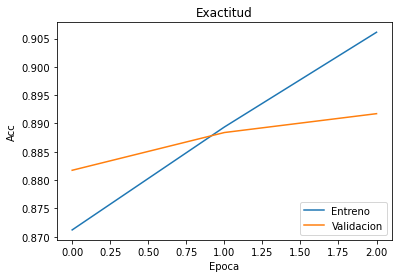

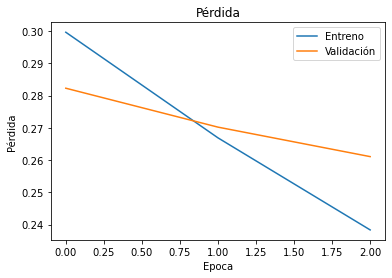

In [38]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc = 'lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [39]:
# B-RNN LSTM
model_cnnrms = load_model('CNNrms_part=3.h5')

model_cnnrms.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_14 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          12320     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 250)               8250      
_________________________________________________________________
dense_9 (Dense)              (None, 1)               

Replicamos los resultados obtenidos anteriormente:

In [40]:
Y_predt = model_cnnrms.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_cnnrms.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[ 9747  2753]
 [ 2068 10432]]
Exactitud:  0.8071600198745728


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [41]:
Y_predv = model_cnnrms.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_cnnrms.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9614  2886]
 [ 2206 10294]]
Exactitud:  0.7963200211524963


Como primera opción, modificamos el optimizado y lo cambiamos por el RMSProp. Los resultados caen en comapración con los anteriores modelos, sienda la exactitud sobre la base de prueba igual a 79.63%. Aunque este resultado es bajo, encontramos una leve mejoria con respecto a la convergencia del modelo con relación a los anteriores modelos. No obstante, a continuación volveremos al modelo de red convolución con la mejor exactitud, pero cambiando la capa de Global MaxPooling por una de Average Pooling.

In [51]:
# Modelo CNN

# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM 
x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D()(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(250, activation = 'relu')(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_16 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 64)          24640     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 250)               16250     
_________________________________________________________________
dense_13 (Dense)             (None, 1)               

In [52]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas = 3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

#Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.3, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('CNNaver_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
547/547 [==============================] - 36s 66ms/step - loss: 0.4092 - accuracy: 0.8039 - val_loss: 0.2895 - val_accuracy: 0.8735
Epoch 2/3
547/547 [==============================] - 38s 69ms/step - loss: 0.1508 - accuracy: 0.9446 - val_loss: 0.3179 - val_accuracy: 0.8807
Epoch 3/3
547/547 [==============================] - 38s 69ms/step - loss: 0.0317 - accuracy: 0.9915 - val_loss: 0.4140 - val_accuracy: 0.8772
Desempeño (exactitud): accu_v1=0.8772000074386597 , accu_v2=0.8718799948692322
Epoch 1/3
547/547 [==============================] - 41s 75ms/step - loss: 0.1263 - accuracy: 0.9562 - val_loss: 0.1318 - val_accuracy: 0.9564
Epoch 2/3
547/547 [==============================] - 35s 65ms/step - loss: 0.0144 - accuracy: 0.9966 - val_loss: 0.1540 - val_accuracy: 0.9580
Epoch 3/3
547/547 [==============================] - 35s 65ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.1581 - val_accuracy: 0.9581
Desempeño (exactitud): accu_v1=0.958133339881897 , accu_v2=0.88

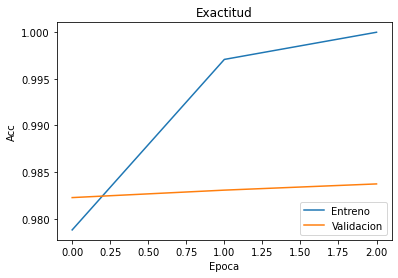

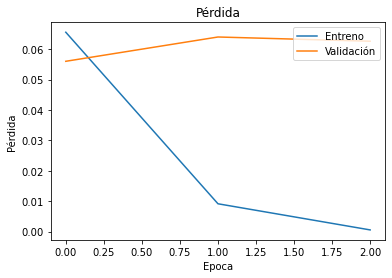

In [53]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc = 'lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [54]:
# B-RNN LSTM
model_cnnaver = load_model('CNNaver_part=3.h5')

model_cnnaver.summary()

Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_16 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 64)          24640     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 250)               16250     
_________________________________________________________________
dense_13 (Dense)             (None, 1)               

Replicamos los resultados obtenidos anteriormente:

In [55]:
Y_predt = model_cnnaver.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_cnnaver.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11830   670]
 [  273 12227]]
Exactitud:  0.9622799754142761


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [56]:
Y_predv = model_cnnaver.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_cnnaver.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10261  2239]
 [  964 11536]]
Exactitud:  0.8718799948692322


Al aumentar el número de neuronas de la primera capa escondida de 32 a 64 podemos observar que la exactitud del modelo mejor y pasa de 86.86% a 87.18%. Dado esto, ¿sera posible mejorar la exactitud del modelo si le agregamos neuronas adicionales a la priemra capa?  

In [63]:
# Modelo CNN

# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM 
x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D()(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(250, activation = 'relu')(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 128)         49280     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 250)               32250     
_________________________________________________________________
dense_18 (Dense)             (None, 1)               

In [64]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas = 3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

#Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.3, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('CNNaver1_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
547/547 [==============================] - 41s 75ms/step - loss: 0.3984 - accuracy: 0.8093 - val_loss: 0.2782 - val_accuracy: 0.8835
Epoch 2/3
547/547 [==============================] - 40s 74ms/step - loss: 0.1415 - accuracy: 0.9485 - val_loss: 0.3125 - val_accuracy: 0.8824
Epoch 3/3
547/547 [==============================] - 41s 75ms/step - loss: 0.0355 - accuracy: 0.9886 - val_loss: 0.3897 - val_accuracy: 0.8879
Desempeño (exactitud): accu_v1=0.8878666758537292 , accu_v2=0.8821200132369995
Epoch 1/3
547/547 [==============================] - 41s 75ms/step - loss: 0.1213 - accuracy: 0.9599 - val_loss: 0.1183 - val_accuracy: 0.9601
Epoch 2/3
547/547 [==============================] - 41s 75ms/step - loss: 0.0105 - accuracy: 0.9975 - val_loss: 0.1382 - val_accuracy: 0.9607
Epoch 3/3
547/547 [==============================] - 41s 75ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.1438 - val_accuracy: 0.9607
Desempeño (exactitud): accu_v1=0.9606666564941406 , accu_v2=0.8

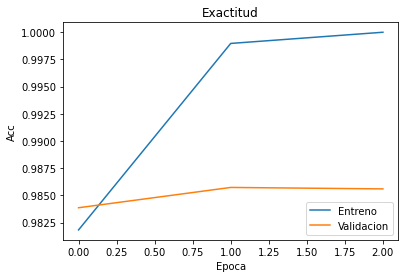

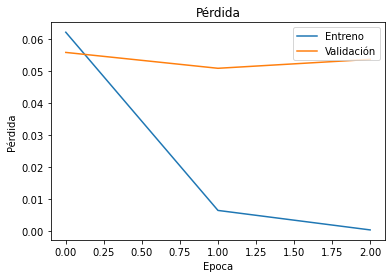

In [65]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc = 'lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [66]:
# B-RNN LSTM
model_cnnaver1 = load_model('CNNaver1_part=3.h5')

model_cnnaver1.summary()

Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 128)         49280     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 250)               32250     
_________________________________________________________________
dense_18 (Dense)             (None, 1)               

Replicamos los resultados obtenidos anteriormente:

In [67]:
Y_predt = model_cnnaver1.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_cnnaver1.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[12018   482]
 [  376 12124]]
Exactitud:  0.9656800031661987


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [68]:
Y_predv = model_cnnaver1.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_cnnaver1.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10907  1593]
 [ 1354 11146]]
Exactitud:  0.8821200132369995


Al pasar de 64 a 128 neuronas en la primera capa escondida vemos que la exactitud mejor con respecto al modelo anterior y pasa de 87.19% a 88.21%, lo que convierte a esta configuración como la que ha dado los mejores resultados.

In [69]:
# Modelo CNN

# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM 
x = layers.Conv1D(250, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D()(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(250, activation = 'relu')(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_19 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 250)         96250     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, None, 250)         0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 250)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 250)               62750     
_________________________________________________________________
dense_20 (Dense)             (None, 1)               

In [70]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas = 3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

#Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.3, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('CNNaver2_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
547/547 [==============================] - 49s 89ms/step - loss: 0.3962 - accuracy: 0.8089 - val_loss: 0.2793 - val_accuracy: 0.8797
Epoch 2/3
547/547 [==============================] - 50s 91ms/step - loss: 0.1508 - accuracy: 0.9429 - val_loss: 0.3102 - val_accuracy: 0.8837
Epoch 3/3
547/547 [==============================] - 50s 92ms/step - loss: 0.0406 - accuracy: 0.9858 - val_loss: 0.3830 - val_accuracy: 0.8861
Desempeño (exactitud): accu_v1=0.8861333131790161 , accu_v2=0.8828399777412415
Epoch 1/3
547/547 [==============================] - 49s 90ms/step - loss: 0.1189 - accuracy: 0.9588 - val_loss: 0.1207 - val_accuracy: 0.9603
Epoch 2/3
547/547 [==============================] - 49s 90ms/step - loss: 0.0107 - accuracy: 0.9976 - val_loss: 0.1380 - val_accuracy: 0.9605
Epoch 3/3
547/547 [==============================] - 49s 90ms/step - loss: 7.0040e-04 - accuracy: 1.0000 - val_loss: 0.1463 - val_accuracy: 0.9617
Desempeño (exactitud): accu_v1=0.961733341217041 , accu_v2=

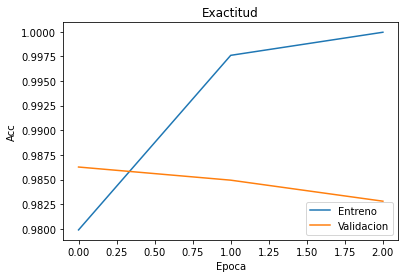

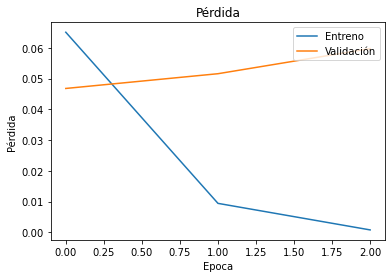

In [71]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc = 'lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [72]:
# B-RNN LSTM
model_cnnaver2 = load_model('CNNaver2_part=3.h5')

model_cnnaver2.summary()

Model: "functional_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_19 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 250)         96250     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, None, 250)         0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 250)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 250)               62750     
_________________________________________________________________
dense_20 (Dense)             (None, 1)               

Replicamos los resultados obtenidos anteriormente:

In [73]:
Y_predt = model_cnnaver2.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_cnnaver2.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11983   517]
 [  353 12147]]
Exactitud:  0.9652000069618225


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [74]:
Y_predv = model_cnnaver2.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_cnnaver2.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10894  1606]
 [ 1323 11177]]
Exactitud:  0.8828399777412415


Como último modelo, intentamos aumentar a 250 el número de neuronas de la primera capa escondida, loq ue da como resultado una exactitud igual a 88.28%, muy similar a la que encontramos cuando se usand 128 neuronas. Por lo tanto, es posible asumir que seguir aumentando el número de neuronas de la primera capa puede no generar mayores incrementos en la exactitud. No obstante, es importante anotar que este sigue siendo el mejor modelo de clasificación encontrado hasta el momento.

Por otro lado otra estrategia a utilizar puede ser la de realizar un preprocesamiento de las palabras mas efectivo utilizando vectorizadores de palabras como GLOVE (Global vectors for word representation) el cual es un algoritmo no supervisado desarrollado por la universidad de Stanford en donde ser entrenó el modelo de vectorizacion con mas de 2.2 M de palabras en el vocabulario. De esta forma con un efoque de aprendizaje por transferencia el modelo puede tener una capa de embedding que aporten mayor informacion ayudando a mejorar el performance del modelo. 